<a href="https://colab.research.google.com/github/ArfianAl/Bullience-ML-Bangkit-Team/blob/main/Klasifikasi_Bully_Model_Revisi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
import re
import string
import nltk
nltk.download('stopwords')
sns.despine()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 640x480 with 0 Axes>

In [2]:
pip install openpyxl

# **READ DATASET**

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
ds= pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Datasets/DATASETS GABUNGAN BULLIENCE.csv")
ds

,id,teks,label
0,1,"Kaka tidur yaa, udah pagi, gaboleh capek2",Non-bullying
1,2,makan nasi padang aja begini badannya,Non-bullying
2,3,yang aku suka dari dia adalah selalu cukur jem...,Bullying
3,4,Hai kak Isyana aku ngefans banget sama kak Isy...,Non-bullying
4,5,Manusia apa bidadari sih herann deh cantik ter...,Non-bullying
...,...,...,...
1045,1046,Bangga sama suami yg selalu ingat istri disela...,Non-bullying
1046,1047,Apaoun pekerjaannya yg penting halal u tuk men...,Non-bullying
1047,1048,Gojek itu mayoritas pegangguran yang lama gak ...,Non-bullying
1048,1049,<USERNAME> aslinya cantik dan ayu loh mbak krn...,Non-bullying


# **DATA PREPROCESSING**

In [10]:
#info dataset
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1050 non-null   int64 
 1   teks    1050 non-null   object
 2   label   1050 non-null   object
 3   Length  1050 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 32.9+ KB


In [11]:
# Checking for null values
ds.isnull().values.any()

False

In [12]:
# Melihat jumlah masing-masing tipe
ds['label'].value_counts()

Non-bullying    525
Bullying        525
Name: label, dtype: int64

Counter({'Non-bullying': 525, 'Bullying': 525})


<Axes: xlabel='label', ylabel='count'>

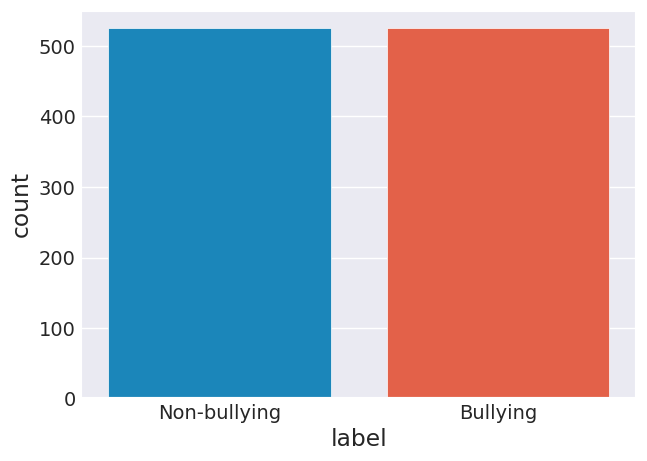

In [13]:
# Distribusi Target
x = ds.teks
y = ds.label

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

count    525.000000
mean      15.417143
std       12.487982
min        3.000000
25%        8.000000
50%       12.000000
75%       18.000000
max      152.000000
Name: Length, dtype: float64

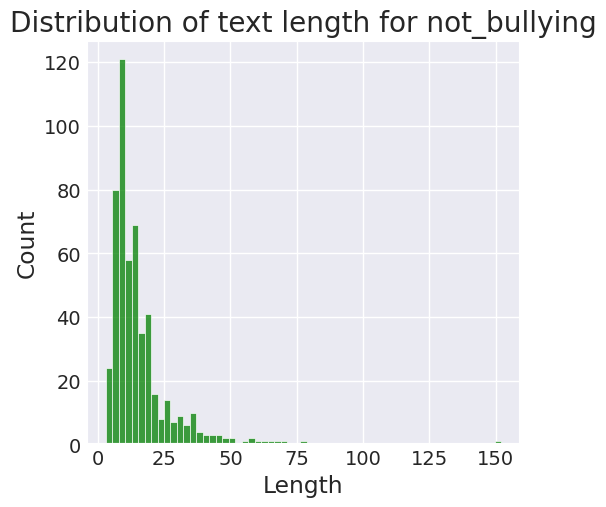

In [14]:
# Melihat statistical description serta histogram panjang teks Non-B
ds["Length"] = ds.teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(ds[ds["label"]=="Non-bullying"]['Length'],color="g")
plt.title("Distribution of text length for not_bullying")
display(ds.Length[ds["label"]=="Non-bullying"].describe())

count    525.000000
mean      15.676190
std       13.125128
min        2.000000
25%        7.000000
50%       10.000000
75%       19.000000
max       73.000000
Name: Length, dtype: float64

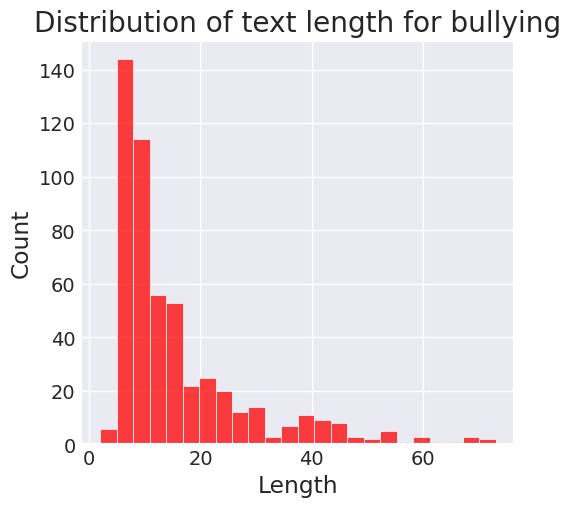

In [15]:
# Melihat statistical description serta histogram panjang teks B
ds["Length"] = ds.teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(ds[ds["label"]=="Bullying"]['Length'],color="r")
plt.title("Distribution of text length for bullying")
display(ds.Length[ds["label"]=="Bullying"].describe())

In [16]:
# variabel untuk kolom teks
texts = ds.teks
print(texts.head())

0            Kaka tidur yaa, udah pagi, gaboleh capek2
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    Hai kak Isyana aku ngefans banget sama kak Isy...
4    Manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object


In [17]:
# Case Folding
# gunakan fungsi series.str.lower() pada Pandas
texts = texts.str.lower()

print(texts.head())

0            kaka tidur yaa, udah pagi, gaboleh capek2
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object


In [18]:
def remove_special_signs(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

texts = texts.apply(remove_special_signs)
print(texts.head())

0            kaka tidur yaa, udah pagi, gaboleh capek2
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object


In [19]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

texts = texts.apply(remove_number)
texts.head(5)

0             kaka tidur yaa, udah pagi, gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object

In [20]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

texts = texts.apply(remove_punctuation)
texts.head(5)

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik terus 
Name: teks, dtype: object

In [21]:
#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

texts = texts.apply(remove_whitespace_LT)
print(texts.head())

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4     manusia apa bidadari sih herann deh cantik terus
Name: teks, dtype: object


In [22]:
# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

texts = texts.apply(remove_whitespace_multiple)
print(texts.head())

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4     manusia apa bidadari sih herann deh cantik terus
Name: teks, dtype: object


In [23]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

texts = texts.apply(remove_singl_char)
print(texts.head())

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4     manusia apa bidadari sih herann deh cantik terus
Name: teks, dtype: object


In [24]:
# Filtering - Stopword Removal
from nltk.corpus import stopwords
# Get Indonesian stopwords
list_stopwords = stopwords.words('indonesian')

# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja',
                       'nyg', 'hehe', 'pen', 'nan', 'loh',
                       '&amp', 'yah',])

# read txt stopword using pandas
csv_stopword = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Datasets/stopwordsID.csv")

# convert stopword string to list & append additional stopword
list_stopwords.extend(csv_stopword)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

texts = texts.apply(stopwords_removal)


print(texts.head())

0    [k, a, k, a,  , t, i, u, r,  , y, a, a,  , u, ...
1    [m, a, k, a, n,  , n, a, s, i,  , p, a, a, n, ...
2    [y, a, n, g,  , a, k, u,  , s, u, k, a,  , a, ...
3    [h, a, i,  , k, a, k,  , i, s, y, a, n, a,  , ...
4    [m, a, n, u, s, i, a,  , a, p, a,  , b, i, a, ...
Name: teks, dtype: object


In [25]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

ds['teks'] = ds['teks'].apply(normalize_text)

In [26]:
# Normalisasi
normalized_word = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Datasets/kamus_singkatan.csv")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

texts = texts.apply(normalized_term)

texts.head(10)

0    [k, a, k, a,  , t, i, u, r,  , y, a, a,  , u, ...
1    [m, a, k, a, n,  , n, a, s, i,  , p, a, a, n, ...
2    [y, a, n, g,  , a, k, u,  , s, u, k, a,  , a, ...
3    [h, a, i,  , k, a, k,  , i, s, y, a, n, a,  , ...
4    [m, a, n, u, s, i, a,  , a, p, a,  , b, i, a, ...
5    [k, i, n, a, n, t, i, i,  , i, s, y, a, n,  , ...
6    [g, e, m, e, s, n, y, a,  , i, s, y, a, n,  , ...
7    [m, a, k, i, n,  , j, e, l, e, k,  , a, j, a, ...
8    [k, o, k,  , a, n, a, k, n, y, a,  , k, a, y, ...
9    [m, u, k, a,  , a, n, a, k,  , n, y, a,  , k, ...
Name: teks, dtype: object

In [27]:
# convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.
# Inisialisasi variabel target
y = ds["label"]
#mengubah y menjadi integer
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print(y)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [28]:
# Menghitung jumlah value integer sentimen
ds["label"].value_counts()

Non-bullying    525
Bullying        525
Name: label, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

ds['teks'] = ds['teks'].apply(normalize_text)

In [31]:
# Tokenisasi dan stemming
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# Contoh pemisahan dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(ds['teks'], ds['label'], test_size=0.2, random_state=42)

# Representasi vektor menggunakan CountVectorizer
vectorizer = CountVectorizer(tokenizer=tokenize_and_stem, max_features=5000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Transformasi TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Encoding label kategori menggunakan LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **BUILD MODEL**

In [32]:

#untuk menentukan size untuk proses embedding, kalimat input sequence huruf akan diubah menjadi word embedding.
#definisi word embedding menyusul
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(62, input_shape=(3549,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
# #layer embedding
# model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
# #Yang digunakan adalah CNN 1-dimensi
# model.add(tf.keras.layers.Conv1D(32,2,activation="relu"))
# model.add(tf.keras.layers.MaxPooling1D(5))
# #32 adalah filter, 8 unit convolution,
# #setelah convolution, pasti ada max pooling, max pooling 1 dimension
# model.add(MaxPooling1D(2,2))
# #Dropout adalah bentuk konfigurasi supaya tidak overfitting
# model.add(Dropout(0.2))
# model.add(Dense(64, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(2,2))
# #model LSTM
# #layer utk mengubah sequence index kata menjadi vektor
# model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
# model.add(Dropout(0.2))
# #layer klasifikasi akhir
# model.add(Dense(2, activation='softmax'))
# #Compile Model
#model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 62)                220100    
                                                                 
 dropout (Dropout)           (None, 62)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2016      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 222149 (867.77 KB)
Trainable params: 222149 (867.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Learning Rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Kompilasi model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [34]:
# Pelatihan model
model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
24/24 [==============================] - 2s 26ms/step - loss: 0.6928 - accuracy: 0.5013 - val_loss: 0.6899 - val_accuracy: 0.5952
Epoch 2/10
24/24 [==============================] - 0s 14ms/step - loss: 0.6859 - accuracy: 0.6442 - val_loss: 0.6843 - val_accuracy: 0.7143
Epoch 3/10
24/24 [==============================] - 0s 13ms/step - loss: 0.6678 - accuracy: 0.7606 - val_loss: 0.6678 - val_accuracy: 0.7143
Epoch 4/10
24/24 [==============================] - 0s 13ms/step - loss: 0.6189 - accuracy: 0.8558 - val_loss: 0.6203 - val_accuracy: 0.7857
Epoch 5/10
24/24 [==============================] - 0s 15ms/step - loss: 0.5125 - accuracy: 0.9180 - val_loss: 0.5388 - val_accuracy: 0.7976
Epoch 6/10
24/24 [==============================] - 0s 13ms/step - loss: 0.3515 - accuracy: 0.9524 - val_loss: 0.4659 - val_accuracy: 0.7976
Epoch 7/10
24/24 [==============================] - 0s 13ms/step - loss: 0.2210 - accuracy: 0.9735 - val_loss: 0.4237 - val_accuracy: 0.8214
Epoch 8/10
24

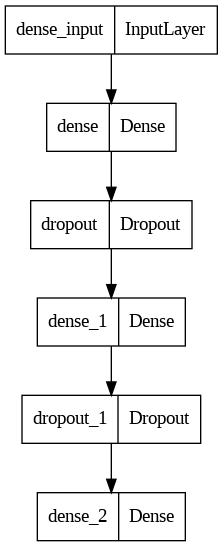

In [30]:
#Plotting model
plot_model(model)

In [35]:
history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0514 - accuracy: 0.9947 - val_loss: 0.4448 - val_accuracy: 0.8095
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0362 - accuracy: 0.9987 - val_loss: 0.4774 - val_accuracy: 0.7976
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.4605 - val_accuracy: 0.8214
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9947 - val_loss: 0.4936 - val_accuracy: 0.8095
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.4983 - val_accuracy: 0.8214
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.9974 - val_loss: 0.5189 - val_accuracy: 0.8214
Epoch 7/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.5286 - val_accuracy: 0.8214
Epoch 8/10
24/24 [=

In [36]:
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_encoded)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

7/7 [==============================] - 0s 5ms/step - loss: 0.4085 - accuracy: 0.8619
Test Loss: 0.40851250290870667, Test Accuracy: 0.8619047403335571


In [37]:
predictions = model.predict(X_test_tfidf.toarray())

7/7 [==============================] - 0s 3ms/step


In [38]:
predicted_labels = label_encoder.inverse_transform((predictions > 0.5).astype('int').ravel())

In [ ]:
model.save('Model_Bully.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
from sklearn.metrics import accuracy_score

In [40]:
# Melakukan prediksi pada data uji
predictions = model.predict(X_test_tfidf.toarray())

# Thresholding untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test_encoded, predicted_labels)
print(f'Accuracy: {accuracy}')


7/7 [==============================] - 0s 3ms/step
Accuracy: 0.861904761904762


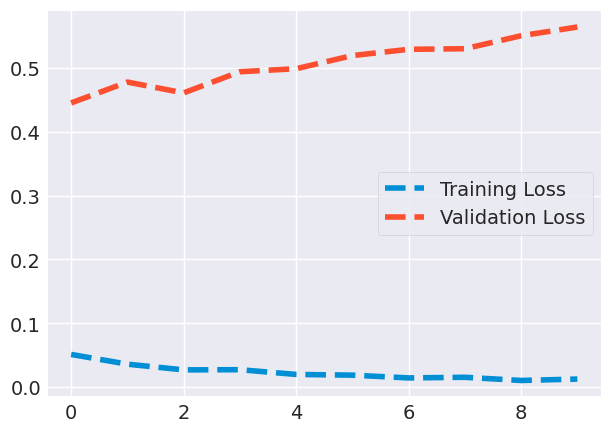

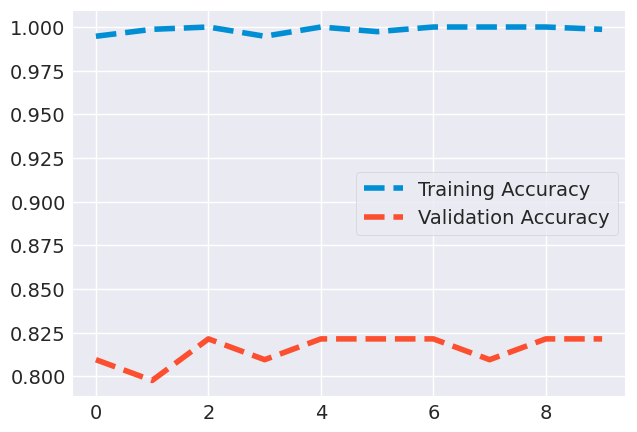

In [41]:
import matplotlib.pyplot as plt

#history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, validation_data=(X_test_tfidf.toarray(), y_test_encoded))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import accuracy_score, classification_report

# Melakukan prediksi pada data uji
predictions = model.predict(X_test_tfidf.toarray())

# Menggunakan threshold untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test_encoded, predicted_labels)
print(f'Accuracy: {accuracy}')

# Classification Report
print(classification_report(y_test_encoded, predicted_labels))


7/7 [==============================] - 0s 3ms/step
Accuracy: 0.861904761904762
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.89      0.83      0.86       105

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210



In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

### TESTING MODEL WITH TEKS

### CASE 1

In [ ]:
# Fungsi untuk preprocessing dan stemming
def preprocess_and_stem(text):
    # Lowercasing
    text = text.lower()

    # Menghapus URL
    text = re.sub(r'http\S+', '', text)

    # Menghapus tanda baca dan angka
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenisasi
    words = nltk.word_tokenize(text)

    # Menghapus stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Menggabungkan kembali kata-kata menjadi teks
    text = ' '.join(words)

    return text

# Fungsi untuk memprediksi label dari teks
def predict_label(text, model, vectorizer):
    # Preprocessing dan stemming teks
    processed_text = preprocess_and_stem(text)

    # Vectorization menggunakan CountVectorizer
    text_vectorized = vectorizer.transform([processed_text])

    # Melakukan prediksi menggunakan model
    prediction = model.predict(text_vectorized.toarray())

    return prediction[0][0]

In [ ]:
path_model = 'model_violence.h5'
model = tf.keras.models.load_model(path_model)

In [ ]:
import pickle
# Menyimpan vectorizer
with open('path_vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
# Gantilah path_vectorizer dengan path tempat menyimpan objek CountVectorizer
path_vectorizer = 'path_vectorizer'
with open(path_vectorizer, 'rb') as f:
    vectorizer = pickle.load(f)

In [ ]:
# Teks yang akan diuji
text_to_test = "Contoh teks untuk pengujian model."

# Melakukan prediksi label
prediction = predict_label(text_to_test, model, vectorizer)

# Menggunakan threshold untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_label = 1 if prediction > threshold else 0

print(f'Teks: {text_to_test}')
print(f'Hasil Prediksi: {predicted_label}')

1/1 [==============================] - 0s 50ms/step
Teks: Contoh teks untuk pengujian model.
Hasil Prediksi: 0


<ipython-input-93-31471df47f30>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-whitegrid'])


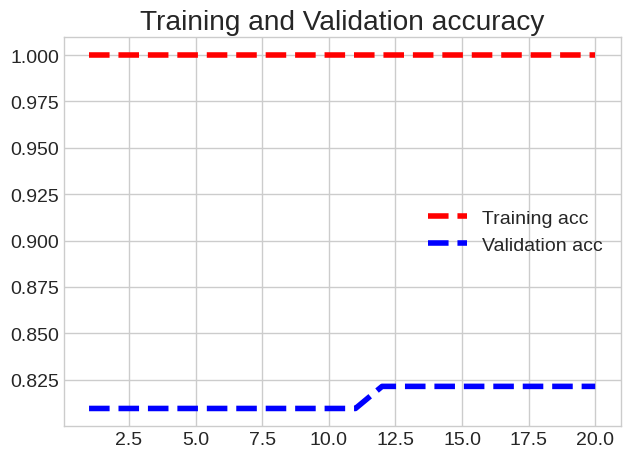

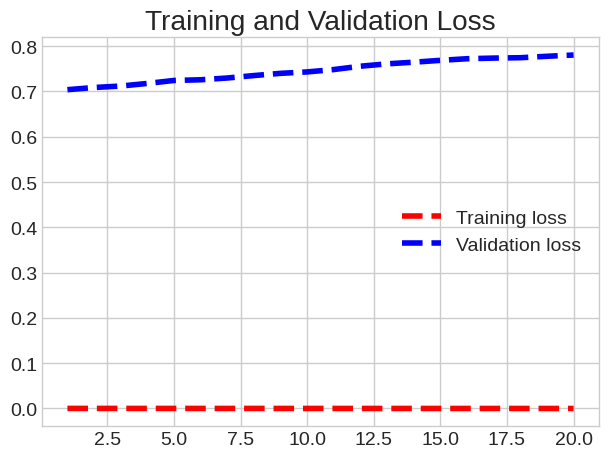

In [ ]:
#Plot training validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use(['seaborn-whitegrid'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'b'])
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Akurasi model
accuracy = model.evaluate(X_test, y_test)
print("Accuracy of the model is: ", accuracy)

ValueError: ignored

In [ ]:
#Evaluasi
print("Model Performance of CNN (Test Accuracy)")
print('Accuracy: {:0.2f}%\nLoss: {:0.2f}%\n'.format(accuracy[1]*100, accuracy[0]))

In [ ]:
model.save('model_bully.h5')

### CASE 2

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  roc_curve, auc
from sklearn.model_selection import cross_val_score

In [45]:
# Evaluasi model pada data uji
y_pred = model.predict(X_test_tfidf.toarray())
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_encoded = np.array(y_test_encoded)

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_test_encoded, predicted_labels))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_encoded, predicted_labels))

# 3. Accuracy Score
accuracy = accuracy_score(y_test_encoded, predicted_labels)
print(f"\nAccuracy Score: {accuracy * 100:.2f}%")

# 4. Cross-Validation
#cv_scores = cross_val_score(model, X_train_tfidf.toarray(), y_train_encoded, cv=5)
#print("\nCross-Validation Scores:")
#print(cv_scores)
#print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")

7/7 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.89      0.83      0.86       105

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210


Confusion Matrix:
[[94 11]
 [18 87]]

Accuracy Score: 86.19%


7/7 [==============================] - 0s 7ms/step
Confusion Matrix:
[[105   0]
 [105   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.89      0.83      0.86       105

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210

7/7 [==============================] - 0s 7ms/step


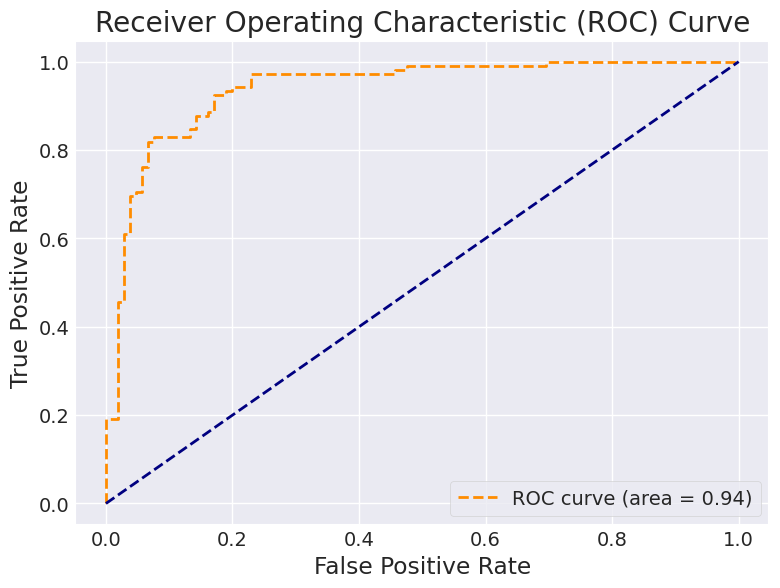

In [50]:
# Prediksi label pada data uji
y_pred = model.predict(X_test_tfidf.toarray())


# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test_encoded,predicted_labels)
print("Classification Report:")
print(class_report)

# Kurva ROC-AUC
y_pred_prob = model.predict(X_test_tfidf.toarray())
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualisasi Kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [57]:
import numpy as np

# Fungsi untuk melakukan normalisasi dan tokenisasi pada teks
def preprocess_text(text):
    normalized_text = normalize_text(text)
    tokenized_text = tokenize_and_stem(normalized_text)
    return ' '.join(tokenized_text)

# Contoh teks untuk pengujian
test_text = "aku melihat teman saya dibully sampe kena mental"


# Normalisasi dan tokenisasi teks pengujian
preprocessed_text = preprocess_text(test_text)

# Representasi vektor menggunakan CountVectorizer dan TF-IDF Transformer
test_text_vectorized = vectorizer.transform([preprocessed_text])
test_text_tfidf = tfidf_transformer.transform(test_text_vectorized)

# Prediksi label
predictions = model.predict(test_text_tfidf.toarray())
predicted_label_index = np.argmax(predictions)
predicted_label = label_encoder.classes_[predicted_label_index]

# Konversi probabilitas menjadi label
predik_label = 1 if predictions > 0.5 else 0

    # Tampilkan hasil prediksi dan persentase
if predik_label > 0.5:
        sentiment = 'Positif'
        confidence = predictions * 100
else:
        sentiment = 'Negatif'
        confidence = (1 - predictions) * 100

print(f'Teks: {test_text}')
print(f'Predicted Label: {predicted_label}')
print(f'Kepercayaan: {confidence:.2f}%\n')


1/1 [==============================] - 0s 39ms/step
Teks: aku melihat teman saya dibully sampe kena mental
Predicted Label: Bullying


TypeError: ignored

In [56]:
# Testing model dengan data teks array
new_texts = ["aku melihat teman saya dibully sampe kena mental", "Contoh teks 2", "Contoh teks 3"]
new_texts_normalized = [normalize_text(text) for text in new_texts]
new_texts_vectorized = vectorizer.transform(new_texts_normalized)
new_texts_tfidf = tfidf_transformer.transform(new_texts_vectorized.toarray())

# Prediksi label
new_texts_pred = model.predict(new_texts_tfidf.toarray())
new_texts_pred_classes = np.argmax(new_texts_pred, axis=1)

# Decoding label menggunakan LabelEncoder
new_texts_pred_labels = label_encoder.inverse_transform(new_texts_pred_classes)

# Tampilkan hasil prediksi
for i in range(len(new_texts)):
    print(f"Text: {new_texts[i]}, Predicted Label: {new_texts_pred_labels[i]}")

1/1 [==============================] - 0s 68ms/step
Text: aku melihat teman saya dibully sampe kena mental, Predicted Label: Bullying
Text: Contoh teks 2, Predicted Label: Bullying
Text: Contoh teks 3, Predicted Label: Bullying


In [13]:
from nltk.corpus import stopwords

In [9]:
model = load_model('Model_Bullying.h5')

In [14]:
import numpy as np

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Fungsi untuk mendapatkan kategori berdasarkan range persentase
def get_category(percentage):
    if percentage < 0.33:
        return 'Ringan'
    elif 0.33 <= percentage < 0.67:
        return 'Sedang'
    else:
        return 'Berat'

# Fungsi untuk menampilkan hasil testing dengan label, persentase, dan kategori
def test_model(model, texts):
    # Normalisasi teks pada data uji
    normalized_texts = [normalize_text(text) for text in texts]

    # Representasi vektor menggunakan CountVectorizer dan TF-IDF Transformer
    text_counts = vectorizer.transform(normalized_texts)
    text_tfidf = tfidf_transformer.transform(text_counts)

    # Prediksi label pada data uji baru
    predictions = model.predict(text_tfidf.toarray())

    # Decode label yang telah di-encode sebelumnya
    decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    # Menampilkan hasil prediksi
    for i in range(len(texts)):
        label = decoded_predictions[i]
        confidence = np.max(predictions[i]) * 100
        category = get_category(confidence / 100)  # Konversi persentase ke range 0-1

        print(f'Teks: {texts[i]}')
        print(f'Prediksi: {label}')
        print(f'Persentase: {confidence:.2f}%')
        print(f'Kategori: {category}')
        print()

# Contoh data teks untuk pengujian
test_texts = ["aku melihat teman saya dibully sampe kena mental.", "Contoh teks 2 untuk pengujian."]

# Melakukan pengujian model
test_model(model, test_texts)


NameError: ignored

In [60]:
model.save('Model_Bullying.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
